<a href="https://colab.research.google.com/github/anmutechsupport/PCA-CNN-P300/blob/main/PCA_CNN_P300.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install tensorflow_transform

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import Input, Conv2D, Dense, concatenate, Conv3D
from pprint import pprint
# import tensorflow_transform as tft
import numpy as np
import scipy.io
import pandas as pd
from scipy.signal import butter, lfilter, freqz
from tqdm import tqdm
import os
import re
import pickle
import numpy as np
from scipy.io import loadmat
import seaborn as sns

# import tensorflow.keras.backend as K

In [ ]:
# K.set_image_data_format('channels_last') #does not work
# tf.compat.v1.disable_eager_execution()
tf.compat.v1.enable_eager_execution()

In [ ]:
def minibatch(data, batch_size):
    start = 0
    while True:

        end = start + batch_size
        yield data[start:end]

        start = end
        if start >= len(data):
            break

# function to collect matching files and dirs
def collect_files(root, res, pattern="", collect_dirs=True, min_depth=None, max_depth=None):
    
    # check max depth
    if not max_depth is None and max_depth == 0:
        return
    
    # go through all item in the dir
    for item in os.listdir(root):
        
        # process item
        item_path = os.path.join(root, item)
        item_is_dir = os.path.isdir(item_path)
        
        # pull valid file in res if min depth has reached
        if min_depth is None or min_depth - 1 <= 0:
            if re.match(pattern, item_path):
                if not item_is_dir or collect_dirs:
                    res.append(item_path)
        
        # recursively collect all files
        if item_is_dir:
            next_min_depth = None if min_depth is None else min_depth - 1
            next_max_depth = None if max_depth is None else max_depth - 1
            collect_files(item_path, res, pattern, collect_dirs, next_min_depth, next_max_depth)

# collect the mat files
mat_files = []
collect_files("./", mat_files, pattern=".*\.mat$", collect_dirs=False)
mat_files.sort()
print(mat_files)

# load all data into memory
# all_data[i] means data for ith subject
all_data = []
for i, mat_file in enumerate(mat_files):
    
    # re-index tmp into a dictionary
    tmp = loadmat(mat_file)["data"][0][0]
    tmp = {name: data for name, data in zip(tmp.dtype.names, tmp)}
    
    # rename column
    tmp["x"] = tmp["X"]
    del tmp["X"]
    
    # reshape columns
    tmp["y"] = tmp["y"].reshape(-1)
    tmp["y_stim"] = tmp["y_stim"].reshape(-1)
    tmp["trial"] = tmp["trial"].reshape(-1)
    
    # add subject info
    tmp["subject"] = i + 1
    
    all_data.append(tmp)

pprint(all_data[0])

# constants for data_extraction
sample_rate = 250 #hz
tick_len = 1000 // sample_rate # ms -> 4
pre_epoch = 0 #ms
post_epoch = 700 #ms

raw = all_data[0]['x']
print(np.array(raw.shape))

# give raw eeg data and tick times, return 2d signals
def extract_epochs(raw, ticks):
    pre_tick = int(pre_epoch // tick_len) # 0
    post_tick = int(post_epoch // tick_len) #175
    raw_len = len(raw) #350k+ datapoints -> each experiment is 1400s long -> sampling at 250hz 
    signals = [] 
    for t in ticks:
        if t + post_tick <= raw_len: 
            signal = raw[t-pre_tick:t+post_tick, :] #takes slice of data points, takes all electrodes
            signals.append(signal)
    return np.array(signals) #1st dim == # of sample point ids

# extract epochs for every subject
for i, data in enumerate(all_data):
    
    # extract from raw
    ticks, y_stim, y = data["flash"][:, [0, 2, 3]].T #extracts sample point id, stimulation(0-12), hit/nohits(1/2)
    raw = data["x"]
    
    # get the epochs
    epochs = extract_epochs(raw, ticks) #returning signals -> we only slice from sample point ids, why?
    
    # label the epochs
    for j, x in enumerate(y):
        assert x == 1 or x == 2
        y[j] = 1 if x == 2 else 0 #switching labels from 1/2 to 0/1
    
    # trim extra y and y_stim
    y = y[:len(epochs)] #takes all the labels until # of sample point ids
    y_stim = y_stim[:len(epochs)] #takes all the stim until # of sample point ids
    
    assert len(epochs) == len(y) and len(y) == len(y_stim) # validating stuff that we did in the 2 lines above 
    
    samples = np.array(list(zip(epochs, y, y_stim)), dtype=object) # concatenates everything into an np array
    
    # save the data
    with open(f"s{i+1}.pkl", "wb") as outfile:
        pickle.dump(samples, outfile) #saves sample np array into pkl

print(samples.shape)

with open("s7.pkl", "rb") as infile:
    data = pickle.load(infile)

a = []
for i in data[:, 0]: #appending data batches into 'a'
    a.append(i)

# print('a', np.array(a).shape)
# a = np.array(a).reshape(4200, 8, 175)

# for i in range(1, 9):
#     with open(f"s{i}.pkl", "rb") as infile:
#         data = pickle.load(infile)
#         target = np.sum(data[:, 1]) #Adds all the labels together
#         print(target, len(data) - target) #hits:nohits

data_size = len(data)
print([i for i in data[:, 1]]) #use these to decode with a simple if loop ->  not super sure if each stim represents one flash

# shuffle data
shuffle_idx = np.random.permutation(data_size)
data = data[shuffle_idx]

# 80-20 split train/test
cutoff = int(data_size * 80 // 100)
train_data = data[:cutoff]
val_data = data[cutoff:]

# balance label in the train_data
train_data_size = len(train_data)
train_data_true_count = np.sum([x[1] for x in train_data]) #taking sum of hit labels
train_data_false_count = train_data_size - train_data_true_count #finding # of nohit labels

assert train_data_false_count >= train_data_true_count 

train_data_dup_count = train_data_false_count - train_data_true_count 
train_data_true_idx = np.array([i for i, x in enumerate(train_data) if x[1] == 1])#index array of train data hit labels
train_data_true_sample_idx = np.random.choice(train_data_true_idx, train_data_dup_count, replace=True) #creates random sample indices with and size of dup_count
train_data_addon = train_data[train_data_true_sample_idx] #creates array using indices above

# make sure that all the addon have true labels
assert all([x[1] == 1 for x in train_data_addon])

# stack the addon to the original trainning data and shuffle again
train_data = np.concatenate((train_data, train_data_addon), axis=0)
train_data_size = len(train_data)
shuffle_idx = np.random.permutation(train_data_size)
train_data = train_data[shuffle_idx] #final dataset

'''
'''

# train_data = train_data[:(len(train_data)*10//100)]

# data = np.array([i for i in data[:, 0]])
# labels = np.array(data[:, 1])
# stim = np.array(data[:, 2])
 
T_data = np.array([i for i in train_data[:, 0]])
T_labels = np.array([i for i in train_data[:, 1]])
T_stim = np.array([i for i in train_data[:, 2]])

V_data = np.array([i for i in val_data[:, 0]])
V_labels = np.array([i for i in val_data[:, 1]])
V_stim = np.array([i for i in val_data[:, 2]])

print(len(data))
print(V_labels.shape, T_data.shape)

with open(f"labels.pkl", "wb") as outfile:
  pickle.dump([T_labels, V_labels], outfile)



['./P300S01.mat', './P300S02.mat', './P300S03.mat', './P300S04.mat', './P300S05.mat', './P300S06.mat', './P300S07.mat', './P300S08.mat']
{'flash': array([[  7486,     31,     11,      1],
       [  7548,     31,      5,      1],
       [  7610,     30,      7,      1],
       ...,
       [355688,     32,      3,      2],
       [355750,     32,      7,      1],
       [355813,     32,      4,      1]], dtype=int32),
 'subject': 1,
 'trial': array([  7487,  17511,  27536,  37564,  47590,  57620,  67641,  77667,
        87690,  97715, 107740, 117764, 127790, 137813, 147840, 157867,
       167893, 177915, 187942, 197967, 207995, 218018, 228044, 238068,
       248095, 258119, 268146, 278171, 288194, 298220, 308246, 318273,
       328297, 338325, 348349], dtype=int32),
 'x': array([[26.95640373, 11.73869324,  6.98503304, ...,  2.66381407,
        -3.04957318, -2.63618731],
       [29.94702721, 14.98267174, 10.02626705, ...,  5.16736984,
         1.30663943,  2.16391516],
       [33.09702683

In [ ]:
def standardize_data(arr):
         
    '''
    This function standardize an array, its substracts mean value, 
    and then divide the standard deviation.
    
    param 1: array 
    return: standardized array
    '''    
    rows, columns = arr.shape
    
    standardizedArray = np.zeros(shape=(rows, columns)) 
    tempArray = np.zeros(rows)  
    
    for column in tqdm(range(columns)):
        
        # print(column)
        mean = np.mean(X[:,column]) #mean of channel
        std = np.std(X[:,column]) #std of channel
        tempArray = np.empty(0)
        
        for element in X[:,column]: 
            
            tempArray = np.append(tempArray, ((element - mean) / std)) #row val - mean/std = mean of 0, STD of 1
 
        standardizedArray[:,column] = tempArray
    
    return standardizedArray

ink = np.random.randn(50,64,240) #numpy

PCA_array = [[], []]
datax = [T_data, V_data]

for data in tqdm(datax):
# Standardizing data
  X = data.reshape(len(data)*8, 175) #flatten axis for standardizing
  X = standardize_data(X).reshape(-1, 8, 175)
  # print(X.shape)

  for batch in X:
    # Calculating the covariance matrix
    covariance_matrix = np.cov(batch.T)
    # print(covariance_matrix)

    # Using np.linalg.eig function
    eigen_values, eigen_vectors = np.linalg.eig(covariance_matrix)
    # print("Eigenvector: \n",eigen_vectors,"\n")
    # print("Eigenvalues: \n", eigen_values, "\n")

  # Calculating the explained variance on each of components
    variance_explained = []
    for i in eigen_values:
        variance_explained.append((i/sum(eigen_values))*100)
          
    # print(variance_explained)

  # Identifying components that explain at least 95%

    cumulative_variance_explained = np.cumsum(variance_explained)
    # print(cumulative_variance_explained)

  # Using two first components (because those explain more than 95%)
    projection_matrix = (eigen_vectors.T[:][:60]).T
    # print(projection_matrix)

  # Getting the product of original standardized X and the eigenvectors 
    batch_pca = batch.dot(projection_matrix)
    PCA_array[datax.index(data)].append(batch_pca)

# print(PCA_array)
PCA_array = np.array([np.array(x) for x in PCA_array], dtype=object)
print(PCA_array.shape)
with open(f"PCA1.pkl", "wb") as outfile:
  pickle.dump(PCA_array, outfile)


In [ ]:
with open("PCA1.pkl", "rb") as infile:
    pca = pickle.load(infile)

print(pca[1].shape)

#hold out split
PCA_val, PCA_train = pca[1].reshape(-1, 8, 60, 1),  pca[0].reshape(-1, 8, 60, 1)

PCA_train.shape


# print(PCA_val.shape, PCA_train.shape, labels_val.shape, labels_train.shape, labels.shape)

(840, 8, 60)


(5610, 8, 60, 1)

In [ ]:
with open("labels.pkl", "rb") as infile:
    T_labels, V_labels = pickle.load(infile)

print(T_labels.shape)
print(V_labels.shape)




(5610,)
(840,)


120 dim

In [ ]:
model = models.Sequential()
inp_conc1 = Input(shape=(1, 120, 20))
inp_conc2 = Input(shape=(1, 44, 16))

#l2
model.add(Conv2D(20, (8, 1), activation="relu", strides=(8, 1), padding='same', input_shape=(8, 120, 1))) #just change kernel size here and you should be good to go with any array
# print(L2.shape) #0th index: # of batches, 1st index: height of output, 2nd index: width of output, 3rd index: depth -> # of filters
#l3
L3_1 = Conv2D(filters=16, kernel_size=(1, 5), strides=(1, 5), padding="same", activation="relu", input_shape=(1, 120, 20))(inp_conc1)
# print(L3_1.shape)

L3_2 = Conv2D(filters=16, kernel_size=(1, 10), strides=(1, 10), padding="same", activation="relu", input_shape=(1, 120, 20))(inp_conc1)
# # print(L3_2.shape)

L3_3 = Conv2D(filters=16, kernel_size=(1, 15), strides=(1, 15), padding="same", activation="relu", input_shape=(1, 120, 20))(inp_conc1)
# print(L3_3.shape)

#L4
L3_concat = models.Model(inputs=inp_conc1, outputs=concatenate([L3_1, L3_2, L3_3], axis=2))
model.add(L3_concat)
model.add(tf.keras.layers.Dropout(.5))
# print(dp.shape)

#L5
L5_1 = Conv2D(filters=16, kernel_size=(1, 2), strides=(1, 2), padding="same", activation="relu", input_shape=(1, 44, 16))(inp_conc2)
# print(L5_1.shape)

L5_2 = Conv2D(filters=16, kernel_size=(1, 4), strides=(1, 4), padding="same", activation="relu", input_shape=(1, 44, 16))(inp_conc2)
# print(L5_2.shape)

L5_3 = Conv2D(filters=16, kernel_size=(1, 11), strides=(1, 11), padding="same", activation="relu", input_shape=(1, 44, 16))(inp_conc2)
# print(L5_3.shape)

#L6
L5_concat = models.Model(inputs=inp_conc2, outputs=concatenate([L5_1, L5_2, L5_3], axis=2))
model.add(L5_concat)
model.add(tf.keras.layers.Dropout(.5))
# print(dp2.shape)

#L7
model.add(layers.MaxPooling2D((2, 2), strides=2, padding='same'))
# print(mxpool.shape)

#L8 
model.add(layers.Flatten())
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dense(2, activation='relu'))
# print(dense.shape)
# print(dense2.shape)

#L9
model.add(layers.Softmax(axis=1))
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
print(model.summary())

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_86 (Conv2D)           (None, 1, 120, 20)        180       
_________________________________________________________________
model_24 (Functional)        (None, 1, 44, 16)         9648      
_________________________________________________________________
dropout_24 (Dropout)         (None, 1, 44, 16)         0         
_________________________________________________________________
model_25 (Functional)        (None, 1, 37, 16)         4400      
_________________________________________________________________
dropout_25 (Dropout)         (None, 1, 37, 16)         0         
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 1, 19, 16)         0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 304)             

60 dim

In [ ]:
model = models.Sequential()
inp_conc1 = Input(shape=(1, 60, 20))
inp_conc2 = Input(shape=(1, 22, 16))

#l2
model.add(Conv2D(20, (8, 1), activation="relu", strides=(8, 1), padding='same', input_shape=(8, 60, 1))) #just change kernel size here and you should be good to go with any array
# print(L2.shape) #0th index: # of batches, 1st index: height of output, 2nd index: width of output, 3rd index: depth -> # of filters
#l3
L3_1 = Conv2D(filters=16, kernel_size=(1, 5), strides=(1, 5), padding="same", activation="relu", input_shape=(1, 60, 20))(inp_conc1)
# print(L3_1.shape)

L3_2 = Conv2D(filters=16, kernel_size=(1, 10), strides=(1, 10), padding="same", activation="relu", input_shape=(1, 60, 20))(inp_conc1)
# # print(L3_2.shape)

L3_3 = Conv2D(filters=16, kernel_size=(1, 15), strides=(1, 15), padding="same", activation="relu", input_shape=(1, 60, 20))(inp_conc1)
# print(L3_3.shape)

#L4
L3_concat = models.Model(inputs=inp_conc1, outputs=concatenate([L3_1, L3_2, L3_3], axis=2))
model.add(L3_concat)
model.add(tf.keras.layers.Dropout(.5))
# print(dp.shape)

#L5
L5_1 = Conv2D(filters=16, kernel_size=(1, 2), strides=(1, 2), padding="same", activation="relu", input_shape=(1, 44, 16))(inp_conc2)
# print(L5_1.shape)

L5_2 = Conv2D(filters=16, kernel_size=(1, 4), strides=(1, 4), padding="same", activation="relu", input_shape=(1, 44, 16))(inp_conc2)
# print(L5_2.shape)

L5_3 = Conv2D(filters=16, kernel_size=(1, 11), strides=(1, 11), padding="same", activation="relu", input_shape=(1, 44, 16))(inp_conc2)
# print(L5_3.shape)

#L6
L5_concat = models.Model(inputs=inp_conc2, outputs=concatenate([L5_1, L5_2, L5_3], axis=2))
model.add(L5_concat)
model.add(tf.keras.layers.Dropout(.5))
# print(dp2.shape)

#L7
model.add(layers.MaxPooling2D((2, 2), strides=2, padding='same'))
# print(mxpool.shape)

#L8 
model.add(layers.Flatten())
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dense(2, activation='relu'))
# print(dense.shape)
# print(dense2.shape)

#L9
model.add(layers.Softmax(axis=1))
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
print(model.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_42 (Conv2D)           (None, 1, 60, 20)         180       
_________________________________________________________________
model_12 (Functional)        (None, 1, 22, 16)         9648      
_________________________________________________________________
dropout_12 (Dropout)         (None, 1, 22, 16)         0         
_________________________________________________________________
model_13 (Functional)        (None, 1, 19, 16)         4400      
_________________________________________________________________
dropout_13 (Dropout)         (None, 1, 19, 16)         0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 1, 10, 16)         0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 160)              

Dynamic

In [ ]:
model = models.Sequential()
dim = PCA_val.shape[2]  
inp_conc1 = Input(shape=(1, dim, 20))
inp_conc2 = Input(shape=(1, int(dim/5+dim/10+dim/15), 16))

#l2
model.add(Conv2D(20, (8, 1), activation="relu", strides=(8, 1), padding='same', input_shape=(8, 60, 1))) #just change kernel size here and you should be good to go with any array
# print(L2.shape) #0th index: # of batches, 1st index: height of output, 2nd index: width of output, 3rd index: depth -> # of filters
#l3
L3_1 = Conv2D(filters=16, kernel_size=(1, 5), strides=(1, 5), padding="same", activation="relu")(inp_conc1)
# print(L3_1.shape)

L3_2 = Conv2D(filters=16, kernel_size=(1, 10), strides=(1, 10), padding="same", activation="relu")(inp_conc1)
# # print(L3_2.shape)

L3_3 = Conv2D(filters=16, kernel_size=(1, 15), strides=(1, 15), padding="same", activation="relu")(inp_conc1)
# print(L3_3.shape)

#L4
L3_concat = models.Model(inputs=inp_conc1, outputs=concatenate([L3_1, L3_2, L3_3], axis=2))
model.add(L3_concat)
model.add(tf.keras.layers.Dropout(.5))
# print(dp.shape)

#L5
L5_1 = Conv2D(filters=16, kernel_size=(1, 2), strides=(1, 2), padding="same", activation="relu")(inp_conc2)
# print(L5_1.shape)

L5_2 = Conv2D(filters=16, kernel_size=(1, 4), strides=(1, 4), padding="same", activation="relu")(inp_conc2)
# print(L5_2.shape)

L5_3 = Conv2D(filters=16, kernel_size=(1, 11), strides=(1, 11), padding="same", activation="relu")(inp_conc2)
# print(L5_3.shape)

#L6
L5_concat = models.Model(inputs=inp_conc2, outputs=concatenate([L5_1, L5_2, L5_3], axis=2))
model.add(L5_concat)
model.add(tf.keras.layers.Dropout(.5))
# print(dp2.shape)

#L7
model.add(layers.MaxPooling2D((2, 2), strides=2, padding='same'))
# print(mxpool.shape)

#L8 
model.add(layers.Flatten())
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dense(2, activation=tf.keras.activations.softmax)) #fix this, figure out softmax dense layer
# print(dense.shape)
# print(dense2.shape)

# #L9
# model.add(layers.Softmax(axis=1))

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 1, 60, 20)         180       
_________________________________________________________________
model (Functional)           (None, 1, 22, 16)         9648      
_________________________________________________________________
dropout (Dropout)            (None, 1, 22, 16)         0         
_________________________________________________________________
model_1 (Functional)         (None, 1, 19, 16)         4400      
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 19, 16)         0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 1, 10, 16)         0         
_________________________________________________________________
flatten (Flatten)            (None, 160)               0

Training

In [ ]:
history = model.fit(PCA_train, T_labels, epochs=30, 
                    validation_data=(PCA_val, V_labels))

Epoch 1/30
176/176 [==============================] - 2s 7ms/step - loss: 0.7065 - accuracy: 0.5143 - val_loss: 0.6586 - val_accuracy: 0.7429
Epoch 2/30
176/176 [==============================] - 1s 6ms/step - loss: 0.6850 - accuracy: 0.5504 - val_loss: 0.6306 - val_accuracy: 0.7726
Epoch 3/30
176/176 [==============================] - 1s 6ms/step - loss: 0.6704 - accuracy: 0.5818 - val_loss: 0.6671 - val_accuracy: 0.5702
Epoch 4/30
176/176 [==============================] - 1s 6ms/step - loss: 0.6410 - accuracy: 0.6200 - val_loss: 0.6277 - val_accuracy: 0.6667
Epoch 5/30
176/176 [==============================] - 1s 6ms/step - loss: 0.6127 - accuracy: 0.6563 - val_loss: 0.6004 - val_accuracy: 0.6964
Epoch 6/30
176/176 [==============================] - 1s 7ms/step - loss: 0.5841 - accuracy: 0.6868 - val_loss: 0.5940 - val_accuracy: 0.7036
Epoch 7/30
176/176 [==============================] - 1s 6ms/step - loss: 0.5535 - accuracy: 0.7071 - val_loss: 0.6512 - val_accuracy: 0.5988
Epoch 

27/27 - 0s - loss: 1.1027 - accuracy: 0.7143
(840,)


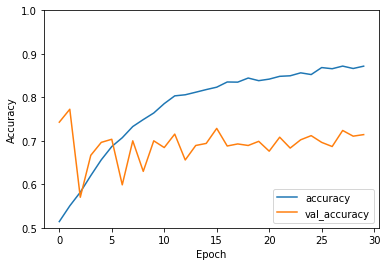

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(PCA_val,  V_labels, verbose=2)
y_pred = np.argmax(model.predict(PCA_val), axis=-1)
print(y_pred.shape) #TRY ARGMAX

# plt.plot(y_pred[:, 0], label='accuracy')
# plt.plot(y_pred[:, 1], label = 'val_accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Pred')
# plt.ylim([0, 1])
# plt.legend(loc='lower right')

In [ ]:
#test data

with open("s4.pkl", "rb") as infile:
    big_data = pickle.load(infile)

print([i for i in big_data[:, 1]]) #use these to decode with a simple if loop ->  not super sure if each stim represents one flash

'''
'''

# train_data = train_data[:(len(train_data)*10//100)]

test_data = np.array([i for i in big_data[:, 0]])
test_labels = np.array([i for i in big_data[:, 1]])
test_stim = np.array([i for i in big_data[:, 2]])

# with open(f"labels.pkl", "wb") as outfile:
#   pickle.dump([T_labels, V_labels], outfile)


[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 

In [ ]:
def standardize_data(arr):
         
    '''
    This function standardize an array, its substracts mean value, 
    and then divide the standard deviation.
    
    param 1: array 
    return: standardized array
    '''    
    rows, columns = arr.shape
    
    standardizedArray = np.zeros(shape=(rows, columns)) 
    tempArray = np.zeros(rows)  
    
    for column in tqdm(range(columns)):
        
        # print(column)
        mean = np.mean(X[:,column]) #mean of channel
        std = np.std(X[:,column]) #std of channel
        tempArray = np.empty(0)
        
        for element in X[:,column]: 
            
            tempArray = np.append(tempArray, ((element - mean) / std)) #row val - mean/std = mean of 0, STD of 1
 
        standardizedArray[:,column] = tempArray
    
    return standardizedArray

PCA_test = []

# Standardizing data
X = test_data.reshape(len(test_data)*8, 175) #flatten axis for standardizing
X = standardize_data(X).reshape(-1, 8, 175)
# print(X.shape)

for batch in tqdm(X):
  # Calculating the covariance matrix
  covariance_matrix = np.cov(batch.T)
  # print(covariance_matrix)

  # Using np.linalg.eig function
  eigen_values, eigen_vectors = np.linalg.eig(covariance_matrix)
  # print("Eigenvector: \n",eigen_vectors,"\n")
  # print("Eigenvalues: \n", eigen_values, "\n")

# Calculating the explained variance on each of components
  variance_explained = []
  for i in eigen_values:
      variance_explained.append((i/sum(eigen_values))*100)
        
  # print(variance_explained)

# Identifying components that explain at least 95%

  cumulative_variance_explained = np.cumsum(variance_explained)
  # print(cumulative_variance_explained)

# Using two first components (because those explain more than 95%)
  projection_matrix = (eigen_vectors.T[:][:60]).T
  # print(projection_matrix)

# Getting the product of original standardized X and the eigenvectors 
  batch_pca = batch.dot(projection_matrix)
  PCA_test.append(batch_pca)

# print(PCA_array)
PCA_test = np.array(PCA_test).real
print(PCA_test.shape)
with open(f"PCA_test.pkl", "wb") as outfile:
  pickle.dump(PCA_test, outfile)


100%|██████████| 4198/4198 [03:55<00:00, 17.85it/s]


(4198, 8, 60)


In [ ]:
with open("PCA_test.pkl", "rb") as infile:
    PCA_test = pickle.load(infile) 

print(PCA_test.shape) 

(4198, 8, 60)


In [ ]:
PCA_test = PCA_test.reshape(4198, 8, 60, 1)

test_loss, test_acc = model.evaluate(PCA_test, test_labels, verbose=2)
y_pred = np.argmax(model.predict(PCA_test), axis=-1) #argmax returns the indice with the value that produces max from function -> eg. armax([0.9, 0.1]) returns 0
print(str(y_pred[:100])+'\n')
print(test_labels[:100]) #TRY ARGMAX



132/132 - 0s - loss: 0.7624 - accuracy: 0.7323
[1 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 0 0 1 1 0 1 0 0 0 0
 0 1 1 0 1 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 1 0 1 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 1]

[0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 0 1 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0]


In [ ]:
#                         1    2    3    4    5    6
char_matrix = np.array([['A', 'B', 'C', 'D', 'E', 'F'], # 7
                        ['G', 'H', 'I', 'J', 'K', 'L'], # 8
                        ['M', 'N', 'O', 'P', 'Q', 'R'], # 9
                        ['S', 'T', 'U', 'V', 'W', 'X'], # 10
                        ['Y', 'Z', '1', '2', '3', '4'], # 11
                        ['5', '6', '7', '8', '9', '0']])# 12

print(char_matrix.shape)


(6, 6)


In [ ]:
#decoder to-do
#for every 120 indices in decode array calculate the x, y coordinates with the highest activations
#try using confidences as a metric to improve accuracy 
import collections

def decode(y_pred, stim):
  words = []
  decode_array = np.array([y_pred, stim]).T
  new_decode = np.array([decode_array[i:i+120] for i in range(0, len(decode_array), 120)], dtype=object)

  for letter in new_decode:
    col_count = []
    row_count = []
    for flash in letter:
      if flash[0] == 1:
        if flash[1] > 6 and flash[1] <= 12:
          col_count.append(flash[1])
        if flash[1] <= 6:
          row_count.append(flash[1])
          
    # print(collections.Counter(col_count))

    y = max(collections.Counter(col_count), key=collections.Counter(col_count).get)
    x = max(collections.Counter(row_count), key=collections.Counter(row_count).get)
    words.append(char_matrix[x-1, y-7])

  return words

  

In [ ]:
predictions = decode(y_pred, test_stim)
answers = decode(test_labels, test_stim)
print(answers)
print(predictions)

['T', 'O', 'K', 'E', 'N', 'M', 'I', 'R', 'A', 'R', 'J', 'U', 'J', 'U', 'Y', 'M', 'A', 'N', 'S', 'O', 'C', 'I', 'N', 'C', 'O', 'J', 'U', 'E', 'G', 'O', 'Q', 'U', 'E', 'S', 'O']
['E', 'P', 'A', 'F', 'Q', 'O', 'I', 'Z', 'C', 'Q', 'V', 'K', 'G', '2', 'M', 'P', 'Y', 'N', 'Z', 'S', '0', 'Q', 'F', 'X', 'F', 'Q', 'Y', 'Z', '8', 'Z', 'G', '1', 'I', 'Z', 'U']


[[2920  578]
 [ 546  154]]


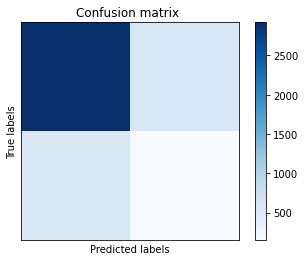

In [ ]:
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import numpy as np

cm = confusion_matrix(test_labels, y_pred)
print(cm)
# or
#cm = np.array([[1401,    0],[1112, 0]])

plt.imshow(cm, cmap=plt.cm.Blues)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.xticks([], [])
plt.yticks([], [])
plt.title('Confusion matrix ')
plt.colorbar()
plt.show()

Without Padding


In [ ]:
ink = (5000, 8, 120, 1)
ink = tf.random.normal(ink)
print(ink.shape)
PCA_train = PCA_train.reshape(504, 8, 120, 1)
#l2
L2 = Conv2D(20, (8, 1), activation="relu", input_shape=(8, 120, 1))(PCA_train)
print(L2.shape) #0th index: # of batches, 1st index: height of output, 2nd index: width of output, 3rd index: depth -> # of filters
#l3
L3_1 = Conv2D(filters=16, kernel_size=(1, 5), strides=5, activation="relu", input_shape=(1, 120, 20))(L2)
print(L3_1.shape)

L3_2 = Conv2D(filters=16, kernel_size=(1, 10), strides=10, activation="relu", input_shape=(1, 120, 20))(L2)
print(L3_2.shape)

L3_3 = Conv2D(filters=16, kernel_size=(1, 15), strides=15, activation="relu", input_shape=(1, 120, 20))(L2)
print(L3_3.shape)

#L4
concatted = concatenate([L3_1, L3_2, L3_3], axis=2) # merge the outputs of the two models
print(concatted.shape)
dp = tf.keras.layers.Dropout(.5)(concatted)
print(dp.shape)

#L5
L5_1 = Conv2D(filters=16, kernel_size=(1, 2), strides=2, activation="relu", input_shape=(1, 44, 16))(dp)
print(L5_1.shape)

L5_2 = Conv2D(filters=16, kernel_size=(1, 4), strides=4, activation="relu", input_shape=(1, 44, 16))(dp)
print(L5_2.shape)

L5_3 = Conv2D(filters=16, kernel_size=(1, 11), strides=11, activation="relu", input_shape=(1, 44, 16))(dp)
print(L5_3.shape)

#L6
concatted2 = concatenate([L5_1, L5_2, L5_3], axis=2) # merge the outputs of the two models
print(concatted2.shape)
dp2 = tf.keras.layers.Dropout(.5)(concatted2)
print(dp2.shape)

#L7
mxpool = layers.MaxPooling2D((2, 2), strides=2)(dp2)
print(mxpool.shape)

#L8 
flat = layers.Flatten()(mxpool)
dense = layers.Dense(100, activation='relu')(flat)
dense2 = layers.Dense(2, activation='relu')(flat)
print(dense.shape)
print(dense2.shape)

#L9
sftymax = layers.Softmax(axis=1)(dense2)
print(sftymax)

(5000, 8, 120, 1)
(504, 1, 120, 20)
(504, 1, 24, 16)
(504, 1, 12, 16)
(504, 1, 8, 16)
(504, 1, 44, 16)
(504, 1, 44, 16)
(504, 1, 22, 16)
(504, 1, 11, 16)
(504, 1, 4, 16)
(504, 1, 37, 16)
(504, 1, 37, 16)
(504, 0, 18, 16)
(504, 100)
(504, 2)
tf.Tensor(
[[0.5 0.5]
 [0.5 0.5]
 [0.5 0.5]
 ...
 [0.5 0.5]
 [0.5 0.5]
 [0.5 0.5]], shape=(504, 2), dtype=float32)


With Padding


In [ ]:
ink = (5000, 8, 60, 1)
ink = tf.random.normal(ink)
print(ink.shape)

#l2
L2 = Conv2D(20, (8, 1), activation="relu", strides=(8, 1), padding="same", input_shape=(8, 60, 1))(ink)
print(L2.shape) #0th index: # of batches, 1st index: height of output, 2nd index: width of output, 3rd index: depth -> # of filters
#L3
L3_1 = Conv2D(filters=16, kernel_size=(1, 5), strides=(1, 5), padding="same", activation="relu")(L2)
print(L3_1.shape)

L3_2 = Conv2D(filters=16, kernel_size=(1, 10), strides=(1, 10), padding="same", activation="relu")(L2)
print(L3_2.shape)

L3_3 = Conv2D(filters=16, kernel_size=(1, 15), strides=(1, 15), padding="same", activation="relu")(L2)
print(L3_3.shape)

#L4
concatted = concatenate([L3_1, L3_2, L3_3], axis=2) # merge the outputs of the two models
print(concatted.shape)
dp = tf.keras.layers.Dropout(.5)(concatted)
print(dp.shape)

# #L5
# L5_1 = Conv2D(filters=16, kernel_size=(1, 2), strides=(1, 2), padding="same", activation="relu", input_shape=(1, 44, 16))(dp)
# print(L5_1.shape)

# L5_2 = Conv2D(filters=16, kernel_size=(1, 4), strides=(1, 4), padding="same", activation="relu", input_shape=(1, 44, 16))(dp)
# print(L5_2.shape)

# L5_3 = Conv2D(filters=16, kernel_size=(1, 11), strides=(1, 11), padding="same", activation="relu", input_shape=(1, 44, 16))(dp)
# print(L5_3.shape)

# #L6
# concatted2 = concatenate([L5_1, L5_2, L5_3], axis=2) # merge the outputs of the two models
# print(concatted2.shape)
# dp2 = tf.keras.layers.Dropout(.5)(concatted2)
# print(dp2.shape)

# #L7
# mxpool = layers.MaxPooling2D((2, 2), strides=2)(dp2)
# print(mxpool.shape)

# #L8 
# flat = layers.Flatten()(mxpool)
# dense = layers.Dense(100, activation='relu')(flat)
# dense2 = layers.Dense(2, activation='relu')(flat)
# print(dense.shape)
# print(dense2.shape)

# #L9
# sftymax = layers.Softmax(axis=1)(dense2)
# print(sftymax)

(5000, 8, 60, 1)
(5000, 1, 60, 20)
(5000, 1, 12, 16)
(5000, 1, 6, 16)
(5000, 1, 4, 16)
(5000, 1, 22, 16)
(5000, 1, 22, 16)
